In [1]:
%matplotlib inline
import os
import sys
import json
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random

import matplotlib.pyplot as plt

### collect information from saved results

In [2]:
data_dir = './test_tasks/'
result_dir = './performance/best_proposed/'

pick_correct = 0 
place_correct = 0
pp_cnt = 0
task_correct = 0
task_cnt = 0
thres = 15
max_thres = 40

total_dist = {'pick':[], 'place':[]}
total_order = {'pick':[], 'place':[]}
total_prev = {'pick':[], 'place':[]}

neutral_dist = {'pick':[], 'place':[]}
neutral_order = {'pick':[], 'place':[]}
neutral_prev = {'pick':[], 'place':[]}

depend_dist = {'pick':[], 'place':[]}
depend_order = {'pick':[], 'place':[]}
depend_prev = {'pick':[], 'place':[]}

explicit_dist = {'pick':[], 'place':[]}
implicit_dist = {'pick':[], 'place':[]}

success_cnt = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}
task_cnt = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}

length_cnt = {3:0, 4:0, 5:0, 6:0}
len_suc_cnt = {3:0, 4:0, 5:0, 6:0}

for d in sorted(os.listdir(data_dir)):
    if d[0] != '.':
        img_dir = os.path.join(data_dir, d, 'image')
        meta_dir = os.path.join(data_dir, d, 'meta')
        
        num_pp = len(os.listdir(img_dir))
        for fp in sorted(os.listdir(meta_dir)):
            gt_meta = json.load(open(os.path.join(meta_dir, fp), 'r'))
            esti_pos = json.load(open(os.path.join(result_dir, d, fp), 'r'))
            num_pp = len(esti_pos['pick'])
            success = True
            num_depend = 0
            for i in range(num_pp):
                explicit = gt_meta['explicit'][i]
                implicit = gt_meta['implicit'][i]
                gt_pick_pos = [(gt_meta['bbox'][i]['pick'][0] + gt_meta['bbox'][i]['pick'][2])/2,
                               (gt_meta['bbox'][i]['pick'][1] + gt_meta['bbox'][i]['pick'][3])/2]
                gt_place_pos = [(gt_meta['bbox'][i]['place'][0] + gt_meta['bbox'][i]['place'][2])/2,
                                (gt_meta['bbox'][i]['place'][1] + gt_meta['bbox'][i]['place'][3])/2]
                esti_pick_pos = esti_pos['pick'][i]
                esti_place_pos = esti_pos['place'][i]
                pick_dist = np.sqrt((gt_pick_pos[0]-esti_pick_pos[0])**2 + (gt_pick_pos[1]-esti_pick_pos[1])**2)#np.linalg.norm(np.array(gt_pick_pos)-np.array(esti_pick_pos))
                place_dist = np.sqrt((gt_place_pos[0]-esti_place_pos[0])**2 + (gt_place_pos[1]-esti_place_pos[1])**2)#np.linalg.norm(np.array(gt_place_pos)-np.array(esti_place_pos))
                
                if pick_dist > thres or place_dist > thres:
                    success = False

                if explicit or implicit:
                    num_depend += 1
                    depend_dist['pick'].append(pick_dist)
                    depend_dist['place'].append(place_dist)
                    depend_order['pick'].append(i+1)
                    depend_order['place'].append(i+1)
                    depend_prev['pick'].append(num_depend)
                    depend_prev['place'].append(num_depend)
                    if explicit:
                        explicit_dist['pick'].append(pick_dist)
                        explicit_dist['place'].append(place_dist)
                    if implicit:
                        implicit_dist['pick'].append(pick_dist)
                        implicit_dist['place'].append(place_dist)
                else:
                    neutral_dist['pick'].append(pick_dist)
                    neutral_dist['place'].append(place_dist)
                    neutral_order['pick'].append(i+1)
                    neutral_order['place'].append(i+1)
                    neutral_prev['pick'].append(num_depend)
                    neutral_prev['place'].append(num_depend)
                    
                total_dist['pick'].append(pick_dist)
                total_dist['place'].append(place_dist)
                total_order['pick'].append(i+1)
                total_order['place'].append(i+1)
                total_prev['pick'].append(num_depend)
                total_prev['place'].append(num_depend)
                
            if success:
                len_suc_cnt[num_pp] += 1
                success_cnt[num_depend] += 1
            task_cnt[num_depend] += 1
            length_cnt[num_pp] += 1

### Graph for average results from all cases

0.8579970104633782
0.793423019431988
0.6947683109118087


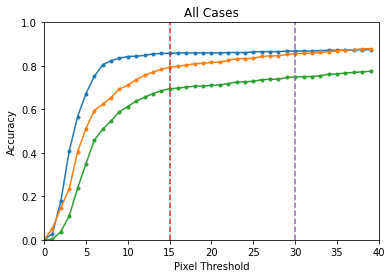

In [3]:
dist_range = np.arange(max_thres)
pick_accu_range = np.array([len([x for x in total_dist['pick'] if x<d])/len(total_dist['pick']) for d in dist_range])
place_accu_range = np.array([len([x for x in total_dist['place'] if x<d])/len(total_dist['place']) for d in dist_range])
both_accu_range = np.array([len([(a,b) for a,b in zip(total_dist['pick'], total_dist['place']) if a<d and b<d])/len(total_dist['place']) for d in dist_range])

plt.plot(dist_range, pick_accu_range, '.-')
plt.plot(dist_range, place_accu_range, '.-')
plt.plot(dist_range, both_accu_range, '.-')
plt.plot([15, 15], [0, 1], '--')
plt.plot([30, 30], [0, 1], '--')

print(pick_accu_range[15])
print(place_accu_range[15])
print(both_accu_range[15])

plt.axis([0, max_thres, 0, 1])
plt.title('All Cases')
plt.xlabel('Pixel Threshold')
plt.ylabel('Accuracy')
plt.show()


### Graph for average results from cases without history dependency

0.8702702702702703
0.828009828009828
0.7302211302211302


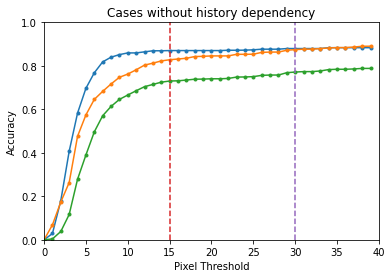

In [4]:
dist_range = np.arange(max_thres)
pick_accu_range = np.array([len([x for x in neutral_dist['pick'] if x<d])/len(neutral_dist['pick']) for d in dist_range])
place_accu_range = np.array([len([x for x in neutral_dist['place'] if x<d])/len(neutral_dist['place']) for d in dist_range])
both_accu_range = np.array([len([(a,b) for a,b in zip(neutral_dist['pick'], neutral_dist['place']) if a<d and b<d])/len(neutral_dist['place']) for d in dist_range])

plt.plot(dist_range, pick_accu_range, '.-')
plt.plot(dist_range, place_accu_range, '.-')
plt.plot(dist_range, both_accu_range, '.-')
plt.plot([15, 15], [0, 1], '--')
plt.plot([30, 30], [0, 1], '--')
plt.axis([0, max_thres, 0, 1])

print(pick_accu_range[15])
print(place_accu_range[15])
print(both_accu_range[15])

neutral_pick = pick_accu_range[15]
neutral_place = place_accu_range[15]
neutral_both = both_accu_range[15]

plt.axis([0, max_thres, 0, 1])
plt.title('Cases without history dependency')
plt.xlabel('Pixel Threshold')
plt.ylabel('Accuracy')
plt.show()


### Graph for average results from cases with history dependency (both explicit and implicit)

0.8389312977099237
0.7396946564885496
0.6396946564885496


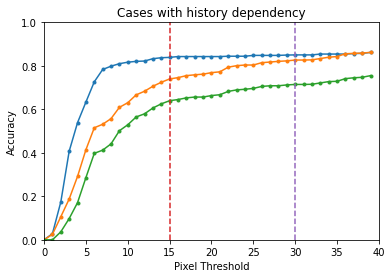

In [5]:
dist_range = np.arange(max_thres)
pick_accu_range = np.array([len([x for x in depend_dist['pick'] if x<d])/len(depend_dist['pick']) for d in dist_range])
place_accu_range = np.array([len([x for x in depend_dist['place'] if x<d])/len(depend_dist['place']) for d in dist_range])
both_accu_range = np.array([len([(a,b) for a,b in zip(depend_dist['pick'], depend_dist['place']) if a<d and b<d])/len(depend_dist['place']) for d in dist_range])

plt.plot(dist_range, pick_accu_range, '.-')
plt.plot(dist_range, place_accu_range, '.-')
plt.plot(dist_range, both_accu_range, '.-')
plt.plot([15, 15], [0, 1], '--')
plt.plot([30, 30], [0, 1], '--')
plt.axis([0, max_thres, 0, 1])

print(pick_accu_range[15])
print(place_accu_range[15])
print(both_accu_range[15])

plt.axis([0, max_thres, 0, 1])
plt.title('Cases with history dependency')
plt.xlabel('Pixel Threshold')
plt.ylabel('Accuracy')
plt.show()

### Graph for average results from cases with explicit history dependency

0.8327526132404182
0.7229965156794426
0.6219512195121951


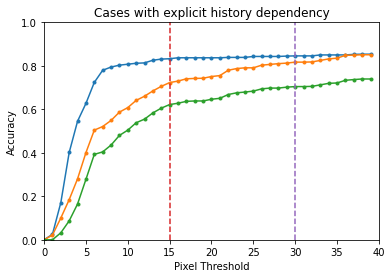

In [6]:
dist_range = np.arange(max_thres)
pick_accu_range = np.array([len([x for x in explicit_dist['pick'] if x<d])/len(explicit_dist['pick']) for d in dist_range])
place_accu_range = np.array([len([x for x in explicit_dist['place'] if x<d])/len(explicit_dist['place']) for d in dist_range])
both_accu_range = np.array([len([(a,b) for a,b in zip(explicit_dist['pick'], explicit_dist['place']) if a<d and b<d])/len(explicit_dist['place']) for d in dist_range])

plt.plot(dist_range, pick_accu_range, '.-')
plt.plot(dist_range, place_accu_range, '.-')
plt.plot(dist_range, both_accu_range, '.-')
plt.plot([15, 15], [0, 1], '--')
plt.plot([30, 30], [0, 1], '--')
plt.axis([0, max_thres, 0, 1])

print(pick_accu_range[15])
print(place_accu_range[15])
print(both_accu_range[15])

plt.axis([0, max_thres, 0, 1])
plt.title('Cases with explicit history dependency')
plt.xlabel('Pixel Threshold')
plt.ylabel('Accuracy')
plt.show()

### Graph for average results from cases with implicit history dependency

0.8299319727891157
0.7959183673469388
0.6836734693877551


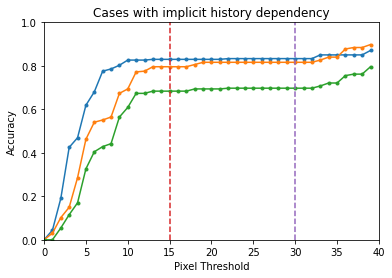

In [7]:
dist_range = np.arange(max_thres)
pick_accu_range = np.array([len([x for x in implicit_dist['pick'] if x<d])/len(implicit_dist['pick']) for d in dist_range])
place_accu_range = np.array([len([x for x in implicit_dist['place'] if x<d])/len(implicit_dist['place']) for d in dist_range])
both_accu_range = np.array([len([(a,b) for a,b in zip(implicit_dist['pick'], implicit_dist['place']) if a<d and b<d])/len(implicit_dist['place']) for d in dist_range])

plt.plot(dist_range, pick_accu_range, '.-')
plt.plot(dist_range, place_accu_range, '.-')
plt.plot(dist_range, both_accu_range, '.-')
plt.plot([15, 15], [0, 1], '--')
plt.plot([30, 30], [0, 1], '--')

plt.axis([0, max_thres, 0, 1])

print(pick_accu_range[15])
print(place_accu_range[15])
print(both_accu_range[15])

plt.axis([0, max_thres, 0, 1])
plt.title('Cases with implicit history dependency')
plt.xlabel('Pixel Threshold')
plt.ylabel('Accuracy')
plt.show()